## **Prueba Analítica: Modelo Opciones de Pago**

### Yeison Andrés Correa Castaño
---

### **Metodología a implementar**

<p align = "justify"> Para el desarrollo de esta prueba análitica, se seguirá el siguiente procedimiento: </p>

- Análisis exploratorio: El análisis exploratorio de datos es una etapa fundamental en el proceso de análisis de datos. Su objetivo es entender la naturaleza y distribución de los datos antes de realizar cualquier modelado o inferencia estadística.  En este análisis exploratorio se realiza un estudio inicial sobre las características del dataset, su origen, tamaño, limpieza de valores nulos (si los hay), correlaciones y gráficas de distribuciones, lo que permite conocer de una manera más clara la información contenida por el dataset.
Una vez se tiene un conocimiento preliminar del comportamiento de los datos, sus principales estadísticas, distribuciones, se procede a realizar un modelamiento de datos. Para esto se debe crear una variable respuesta churn  como variable objetivo y las otras variables como variables dependientes.

- Preprocesamiento y estandarización de datos: Para este problema se utilizará selección de características, en esta parte se detalla el por qué se decide optar por esta solución, luego se estandarizan los datos si es necesario y posteriormente se dividen los datos en los subconjuntos de entrenamiento, testeo y validación.

- Implementación de Modelos de Machine Learning: Se plantean varios modelos de clasificación y se hacen algunos ajustes de hiperparámetros para los modelos.  Al final de cada modelo, se presentan las métricas al evaluar los datos del subconjunto de prueba.

- Análisis de resultados: En esta sección se resumen los resultados obtenidos por todos los modelos de Machine Learning y se selecciona el modelo que presente mejores resultados según los requisitos del problema.

- Conclusiones: Al final de cada sección del documento, se exponen y justifican los resultados obtenidos.

### **Definición del objetivo**

Diseñar y desarrollar un modelo de pronóstico a un mes si aceptará o no una de sus opciones pago

### Importar las librerias necesarias

In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, auc
from ydata_profiling import ProfileReport
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline


In [3]:
# Suprimir advertencias
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

### **Cargar las bases de datos**

In [4]:
# Cargar el archivo CSV
data_rpta = pd.read_csv("prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv")
data_prob = pd.read_csv("prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv")
data_customer = pd.read_csv("prueba_op_master_customer_data_enmascarado_completa.csv")
data_payments = pd.read_csv("prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv")
data_oot= pd.read_csv("prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv")
data_ss= pd.read_csv("sample_submission.csv")

### **Data respuesta o de gestión**
Base de datos que contiene la variable respuesta y las principales características de la gestión.

In [5]:
data_rpta = data_rpta.sort_values(by='fecha_var_rpta_alt', ascending=False)
data_rpta.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,aplicativo,min_mora,max_mora,dias_mora_fin,rango_mora,vlr_obligacion,vlr_vencido,saldo_capital,endeudamiento,desc_alternativa1,desc_alternativa2,desc_alternativa3,cant_alter_posibles,alter_posible1_2,alter_posible2_2,alter_posible3_2,cant_gestiones,cant_gestiones_binario,rpc,promesas_cumplidas,cant_promesas_cumplidas_binario,cant_acuerdo,cant_acuerdo_binario,descripcion_ranking_mejor_ult,descripcion_ranking_post_ult,marca_alt_rank,marca_alt_apli,valor_cuota_mes,pago_cuota,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig
544049,309602,28919,752322,202312,0,e_cero_tipo_2,Banca Pyme,Pymes,TARJETA DE CREDITO,Tarjeta de Credito,V,2,13,0,a.1-30,2605449.0,224751.0,2497081.33,21197557.0,Ampliación de plazo-M,Ampliación 360 -M,Sin alivio,2,TDC10,TDC11,NaN,46.0,1,1.0,0,0,2.0,1,PLAN DE PAGO,PLAN DE PAGO,Cliente compromiso de pago,NO,0.00,0.0,0.0,0.0,0.0,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A
144239,246252,641802,438540,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,63,71,71,b.31-90,3878863.0,600285.0,3593883.00,9750598.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,NaN,NaN,4.0,1,0.0,0,0,2.0,1,PLAN DE COMPROMISO CUMPLIDO,NO CONTESTA,Cliente compromiso de pago,NO,402565.00,0.0,0.0,0.0,0.0,Sin pago,NO,CONSOLIDACION,MODIFICACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa
364740,569401,376139,703712,202312,0,e_cero_tipo_2,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,K,2,14,14,a.1-30,1814615.0,295313.0,1718494.72,1814615.0,Ampliación de plazo-M,Sin alivio,Sin alivio,1,TDC10,NaN,NaN,8.0,1,1.0,0,0,4.0,1,PLAN DE PAGO,PLAN DE PAGO,Cliente compromiso de pago,NO,250357.44,0.0,0.0,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A
144194,538878,498846,581496,202312,0,e_cero_tipo_2,Banca Personas,Personal,ROTATIVOS,Rotativos,L,80,109,109,b.31-90,1104038.0,121556.0,1000000.00,32895700.0,Combo reestructuracion,Prórroga reestructuración,Reestructuración novacion,3,CON24,CON26,CON22,34.0,1,1.0,0,0,0.0,0,NO ACEPTA ACUERDO,N.A,No acepta acuerdo,NO,120998.00,0.0,0.0,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A
144197,55073,828616,251726,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,77,106,106,b.31-90,75279566.0,6587445.0,70106275.32,77774422.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,NaN,NaN,26.0,1,1.0,0,0,0.0,0,ACEPTA ALTERNATIVA,NO CONTESTA,Acepta alternativa,SI,6587444.87,0.0,0.0,0.0,0.0,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa


##### Desde que fecha tiene gestión la base de datos de rpta
- La base tiene gestión de los clientes de 202308 a 202312

In [6]:
data_rpta['fecha_var_rpta_alt'].unique()

array([202312, 202311, 202310, 202309, 202308], dtype=int64)

In [7]:
subset = data_rpta[['nit_enmascarado','num_oblig_orig_enmascarado', 'num_oblig_enmascarado', 'fecha_var_rpta_alt']]

# Verificar si hay filas duplicadas
duplicados_rpta = subset[subset.duplicated()]
duplicados_rpta.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt


No hay duplicados por nits y fecha de gestión

In [8]:
print('Cantidad de filas y columnas:',data_rpta.shape)

Cantidad de filas y columnas: (568251, 49)


Asignar index para tener la base completa

In [9]:

data_rpta.set_index(['nit_enmascarado', 
                     'num_oblig_orig_enmascarado', 
                     'num_oblig_enmascarado', 
                     'fecha_var_rpta_alt'], inplace=True)
data_rpta.head()

,,,,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,aplicativo,min_mora,max_mora,dias_mora_fin,rango_mora,vlr_obligacion,vlr_vencido,saldo_capital,endeudamiento,desc_alternativa1,desc_alternativa2,desc_alternativa3,cant_alter_posibles,alter_posible1_2,alter_posible2_2,alter_posible3_2,cant_gestiones,cant_gestiones_binario,rpc,promesas_cumplidas,cant_promesas_cumplidas_binario,cant_acuerdo,cant_acuerdo_binario,descripcion_ranking_mejor_ult,descripcion_ranking_post_ult,marca_alt_rank,marca_alt_apli,valor_cuota_mes,pago_cuota,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig
nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
309602,28919,752322,202312,0,e_cero_tipo_2,Banca Pyme,Pymes,TARJETA DE CREDITO,Tarjeta de Credito,V,2,13,0,a.1-30,2605449.0,224751.0,2497081.33,21197557.0,Ampliación de plazo-M,Ampliación 360 -M,Sin alivio,2,TDC10,TDC11,NaN,46.0,1,1.0,0,0,2.0,1,PLAN DE PAGO,PLAN DE PAGO,Cliente compromiso de pago,NO,0.00,0.0,0.0,0.0,0.0,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A
246252,641802,438540,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,63,71,71,b.31-90,3878863.0,600285.0,3593883.00,9750598.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,NaN,NaN,4.0,1,0.0,0,0,2.0,1,PLAN DE COMPROMISO CUMPLIDO,NO CONTESTA,Cliente compromiso de pago,NO,402565.00,0.0,0.0,0.0,0.0,Sin pago,NO,CONSOLIDACION,MODIFICACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa
569401,376139,703712,202312,0,e_cero_tipo_2,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,K,2,14,14,a.1-30,1814615.0,295313.0,1718494.72,1814615.0,Ampliación de plazo-M,Sin alivio,Sin alivio,1,TDC10,NaN,NaN,8.0,1,1.0,0,0,4.0,1,PLAN DE PAGO,PLAN DE PAGO,Cliente compromiso de pago,NO,250357.44,0.0,0.0,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A
538878,498846,581496,202312,0,e_cero_tipo_2,Banca Personas,Personal,ROTATIVOS,Rotativos,L,80,109,109,b.31-90,1104038.0,121556.0,1000000.00,32895700.0,Combo reestructuracion,Prórroga reestructuración,Reestructuración novacion,3,CON24,CON26,CON22,34.0,1,1.0,0,0,0.0,0,NO ACEPTA ACUERDO,N.A,No acepta acuerdo,NO,120998.00,0.0,0.0,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A
55073,828616,251726,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,77,106,106,b.31-90,75279566.0,6587445.0,70106275.32,77774422.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,NaN,NaN,26.0,1,1.0,0,0,0.0,0,ACEPTA ALTERNATIVA,NO CONTESTA,Acepta alternativa,SI,6587444.87,0.0,0.0,0.0,0.0,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa


### **Data customer**
- Información asociada a las características generales del cliente o demográficas de forma mensual

In [10]:
data_customer.head()

,nit_enmascarado,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,personas_dependientes,nivel_academico,ocup,act_econom,sector,subsector,declarante,total_ing,tot_activos,tot_pasivos,origen_fondos,f_vinc,f_ult_mantenimiento,canal_actualizacion,cli_actualizado,segm,subsegm,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,year,month,ingestion_day
0,536377,1,PERSONA NATURAL,CLIENTE,F,1998.0,25.0,SOLTERO,FAMILIAR,0.0,0.0,UNIVERSITARIO,ESTUDIANTE,NaN,NaN,NaN,N,2607680.0,33750000.0,0.0,OTROS,20190604,20231222,ACO,N,PERSONAL,MEDIO,MUJERES,CENTRO,SANTANDER,0.0,33750000.0,NaN,1160000.0,2023,12,31
1,512257,1,PERSONA NATURAL,CLIENTE,F,1984.0,38.0,UNION LIBRE,PROPIA,0.0,0.0,TECNOLOGO,EMPLEADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1000000.0,5000000.0,0.0,VENTAS NETAS,20210211,20220427,CMI,N,PERSONAL,MEDIO,MUJERES,CARIBE,MAGDALENA,250000.0,5000000.0,ASALARIADOS,1160000.0,2023,9,30
2,5788,1,PERSONA NATURAL,CLIENTE SOCIAL,M,1960.0,63.0,NaN,NaN,0.0,0.0,NaN,EMPLEADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,0.0,0.0,0.0,SALARIO Y DEMAS PAGOS LABORALES,20200828,20220825,NaN,N,SOCIAL,NaN,NaN,DIRECCIÓN GENERAL,SIN INFORMACION,0.0,0.0,ASALARIADOS,1160000.0,2023,11,30
3,132245,1,PERSONA NATURAL,CLIENTE,F,1982.0,41.0,CASADO,NaN,1.0,0.0,TECNOLOGO,EMPLEADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1800000.0,62513000.0,0.0,SALARIO Y DEMAS PAGOS LABORALES,20100809,20230613,ACD,N,PERSONAL,MEDIO,MUJERES,SUR,VALLE,1000000.0,62513000.0,ASALARIADOS,1160000.0,2023,7,31
4,245279,1,PERSONA NATURAL,CLIENTE,M,1980.0,43.0,CASADO,ALQUILADA,0.0,1.0,NO INFORMA,EMPLEADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,2500000.0,45135000.0,11000000.0,OTROS,20200901,20231019,SVP,N,PERSONAL,MEDIO,NaN,BOGOTA Y CUNDINAMARCA,CALDAS,1000000.0,34135000.0,ASALARIADOS,1160000.0,2023,12,31


In [11]:
data_customer['month'] = data_customer['month'].astype(str).str.zfill(2)
data_customer['year_month'] = data_customer['year'].astype(str)  + data_customer['month']
data_customer = data_customer.drop(columns=['year', 'month', 'ingestion_day'])

In [12]:
# Eliminar filas duplicadas de la base de datos
data_customer = data_customer.drop_duplicates()

# Mostrar el número de filas y columnas después de eliminar duplicados
print("Dimensiones después de eliminar duplicados:", data_customer.shape)


Dimensiones después de eliminar duplicados: (430000, 35)


In [13]:
# Creación de índices para la base de datos
data_customer.set_index(['nit_enmascarado', 
                     'year_month'], inplace=True)
data_customer.head()

,,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,personas_dependientes,nivel_academico,ocup,act_econom,sector,subsector,declarante,total_ing,tot_activos,tot_pasivos,origen_fondos,f_vinc,f_ult_mantenimiento,canal_actualizacion,cli_actualizado,segm,subsegm,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv
nit_enmascarado,year_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536377,202312,1,PERSONA NATURAL,CLIENTE,F,1998.0,25.0,SOLTERO,FAMILIAR,0.0,0.0,UNIVERSITARIO,ESTUDIANTE,NaN,NaN,NaN,N,2607680.0,33750000.0,0.0,OTROS,20190604,20231222,ACO,N,PERSONAL,MEDIO,MUJERES,CENTRO,SANTANDER,0.0,33750000.0,NaN,1160000.0
512257,202309,1,PERSONA NATURAL,CLIENTE,F,1984.0,38.0,UNION LIBRE,PROPIA,0.0,0.0,TECNOLOGO,EMPLEADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1000000.0,5000000.0,0.0,VENTAS NETAS,20210211,20220427,CMI,N,PERSONAL,MEDIO,MUJERES,CARIBE,MAGDALENA,250000.0,5000000.0,ASALARIADOS,1160000.0
5788,202311,1,PERSONA NATURAL,CLIENTE SOCIAL,M,1960.0,63.0,NaN,NaN,0.0,0.0,NaN,EMPLEADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,0.0,0.0,0.0,SALARIO Y DEMAS PAGOS LABORALES,20200828,20220825,NaN,N,SOCIAL,NaN,NaN,DIRECCIÓN GENERAL,SIN INFORMACION,0.0,0.0,ASALARIADOS,1160000.0
132245,202307,1,PERSONA NATURAL,CLIENTE,F,1982.0,41.0,CASADO,NaN,1.0,0.0,TECNOLOGO,EMPLEADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1800000.0,62513000.0,0.0,SALARIO Y DEMAS PAGOS LABORALES,20100809,20230613,ACD,N,PERSONAL,MEDIO,MUJERES,SUR,VALLE,1000000.0,62513000.0,ASALARIADOS,1160000.0
245279,202312,1,PERSONA NATURAL,CLIENTE,M,1980.0,43.0,CASADO,ALQUILADA,0.0,1.0,NO INFORMA,EMPLEADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,2500000.0,45135000.0,11000000.0,OTROS,20200901,20231019,SVP,N,PERSONAL,MEDIO,NaN,BOGOTA Y CUNDINAMARCA,CALDAS,1000000.0,34135000.0,ASALARIADOS,1160000.0


In [14]:
data_customer.shape

(430000, 33)

### **Data payments**
- Describe el comportamiento de pagos del cliente en sus obligaciones a lo largo del tiempo.

In [15]:
data_payments.head()

,nit_enmascarado,num_oblig_enmascarado,fecha_corte,producto,aplicativo,segmento,valor_cuota_mes,pago_total,fecha_pago_minima,fecha_pago_maxima,porc_pago,marca_pago,ajustes_banco
0,482906,362297,20230731,CARTERA MICROCREDITO,L,MICROPYME,311950.0,1862788.0,20230621.0,20230721.0,597.0,PAGO_MENOS,NO
1,121735,186855,20230228,LIBRE INVERSION,L,SOCIAL,131030.0,264157.0,20230127.0,20230207.0,202.0,PAGO_MENOS,NO
2,582719,675503,20231031,TARJETA DE CREDITO,K,PERSONAL,1405339.0,3320.0,20231003.0,20231003.0,0.0,PAGO_MENOS,NO
3,299903,107931,20230228,ROTATIVOS,L,PERSONAL PLUS,19220.0,0.0,NaN,NaN,0.0,FACTURACION_MES_SGTE,NO
4,88625,566060,20230430,ROTATIVOS,L,PERSONAL,384684.0,769368.0,20230403.0,20230403.0,200.0,PAGO_MAS,NO


In [16]:
data_payments.shape

(4855035, 13)

In [17]:
data_payments['fecha_corte'] = data_payments['fecha_corte'].astype(str)
data_payments['año_mes'] = data_payments['fecha_corte'].str[:6]

#### Creación de una base vectorizada de pagos donde se tiene por nit del cliente, nit de la obligación y la fecha, como es la información del cliente en el tiempo

In [18]:
# Crear una columna adicional para identificar los meses en 'año_mes'
data_payments['mes'] = data_payments['año_mes'].str[-2:]  # Asume que 'año_mes' está en formato YYYYMM

# Pivotar los datos para vectorizar las variables
vectorizado = data_payments.pivot_table(
    index=['nit_enmascarado', 'num_oblig_enmascarado', 'año_mes'],  # Variables clave
    columns='mes',  # Los meses se convierten en columnas
    values=['valor_cuota_mes', 'pago_total', 'porc_pago'],  # Variables a vectorizar
    aggfunc='sum'  # Cómo agrupar los valores (puede ser 'sum', 'mean', etc.)
)

# Aplanar las columnas del DataFrame resultante
vectorizado.columns = ['_'.join(map(str, col)) for col in vectorizado.columns]
vectorizado.reset_index(inplace=True)

# Llenar valores acumulados del mes anterior para las variables especificadas
variables = ['valor_cuota_mes', 'pago_total', 'porc_pago']
for var in variables:
    for i in range(1, 13):
        col_name = f'{var}_{i:02d}'
        if col_name in vectorizado.columns:
            vectorizado[col_name] = vectorizado[col_name].fillna(method='ffill')

# Mantener solo las columnas de los meses acumulados de las variables especificadas (del 01 al 12)
cols_to_keep = ['nit_enmascarado', 'num_oblig_enmascarado', 'año_mes'] + \
               [col for col in vectorizado.columns if any(var in col for var in variables) and int(col.split('_')[-1]) <= 12]

vectorizado = vectorizado[cols_to_keep]

# Mostrar las primeras filas del DataFrame vectorizado y ajustado
vectorizado.head()


,nit_enmascarado,num_oblig_enmascarado,año_mes,pago_total_01,pago_total_02,pago_total_03,pago_total_04,pago_total_05,pago_total_06,pago_total_07,pago_total_08,pago_total_09,pago_total_10,pago_total_11,pago_total_12,porc_pago_01,porc_pago_02,porc_pago_03,porc_pago_04,porc_pago_05,porc_pago_06,porc_pago_07,porc_pago_08,porc_pago_09,porc_pago_10,porc_pago_11,porc_pago_12,valor_cuota_mes_01,valor_cuota_mes_02,valor_cuota_mes_03,valor_cuota_mes_04,valor_cuota_mes_05,valor_cuota_mes_06,valor_cuota_mes_07,valor_cuota_mes_08,valor_cuota_mes_09,valor_cuota_mes_10,valor_cuota_mes_11,valor_cuota_mes_12
0,1,104488,202301,206000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102247.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,104488,202302,206000.0,206000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.0,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102247.0,102247.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,104488,202303,206000.0,206000.0,206000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.0,201.0,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102247.0,102247.0,102247.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,104488,202304,206000.0,206000.0,206000.0,23514.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.0,201.0,201.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102247.0,102247.0,102247.0,102247.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,104488,202305,206000.0,206000.0,206000.0,23514.0,142338.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.0,201.0,201.0,23.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102247.0,102247.0,102247.0,102247.0,122102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
vectorizado.shape

(4855019, 39)

### **Base de datos probabilidades**
- Información asociada con los resultados de los modelos analíticos existentes para la cobranza de Bancolombia.


In [20]:
data_prob.head()

,nit_enmascarado,num_oblig_enmascarado,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura
0,296482,102381,202308,1,0.761350,0.193744,0.684784
1,391957,742315,202310,2,0.741803,0.384184,0.483696
2,229894,359919,202307,1,0.835373,0.285157,0.826225
3,478963,239064,202303,3,0.445002,0.629652,0.346508
4,349609,923348,202308,2,0.784365,0.419123,0.667603


In [21]:
data_prob.shape

(4804836, 7)

Verificar si hay duplicados basados en el subset de columnas

In [22]:
duplicados = data_prob[data_prob.duplicated(subset=['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte'], keep=False)]

# Mostrar los duplicados encontrados
duplicados.head()


,nit_enmascarado,num_oblig_enmascarado,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura


In [23]:

# Establecer las columnas como índices
data_prob.set_index(['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte'], inplace=True)


## **Ingeniería de variables**

Se crea una base completa donde se tiene la información mes a mes del cliente

In [24]:
data_customer1 = data_customer.reset_index()

In [25]:

data_customer1['year_month'] = data_customer1['year_month'].astype(str)

# Crear un rango completo de fechas como strings
full_range = pd.date_range(start='2023-07-01', end='2023-12-01', freq='MS').strftime('%Y%m')

# Crear un DataFrame con el rango completo de fechas para cada 'nit_enmascarado'
full_data = pd.DataFrame([(nit, ym) for nit in data_customer1['nit_enmascarado'].unique() for ym in full_range], columns=['nit_enmascarado', 'year_month'])

# Realizar el merge asegurándonos de que los tipos de datos coinciden
data_customer1 = pd.merge(full_data, data_customer1, how='left', on=['nit_enmascarado', 'year_month'])

# Ordenar por 'nit_enmascarado' y 'year_month' antes de rellenar
data_customer1.sort_values(by=['nit_enmascarado', 'year_month'], inplace=True)

# Aplicar el relleno de valores nulos de manera eficiente
data_customer1.update(data_customer1.groupby('nit_enmascarado').ffill())
data_customer1.update(data_customer1.groupby('nit_enmascarado').bfill())

# Mostrar las primeras filas del DataFrame resultante
data_customer1.head()



,nit_enmascarado,year_month,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,personas_dependientes,nivel_academico,ocup,act_econom,sector,subsector,declarante,total_ing,tot_activos,tot_pasivos,origen_fondos,f_vinc,f_ult_mantenimiento,canal_actualizacion,cli_actualizado,segm,subsegm,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv
491982,1,202307,2.0,PERSONA NATURAL,CLIENTE,M,1943.0,80.0,DIVORCIADO,FAMILIAR,2.0,0.0,ESPECIALIZACION,PENSIONADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1934882.0,7776000.0,0.0,OTROS,20081003.0,20230730.0,SVP,N,PERSONAL,ALTO,NaN,BOGOTA Y CUNDINAMARCA,BOGOTÁ,1000000.0,7776000.0,ASALARIADOS,1160000.0
491983,1,202308,2.0,PERSONA NATURAL,CLIENTE,M,1943.0,80.0,DIVORCIADO,FAMILIAR,2.0,0.0,ESPECIALIZACION,PENSIONADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1934882.0,7776000.0,0.0,OTROS,20081003.0,20230730.0,SVP,N,PERSONAL,ALTO,NaN,BOGOTA Y CUNDINAMARCA,BOGOTÁ,1000000.0,7776000.0,ASALARIADOS,1160000.0
491984,1,202309,2.0,PERSONA NATURAL,CLIENTE,M,1943.0,80.0,DIVORCIADO,FAMILIAR,2.0,0.0,ESPECIALIZACION,PENSIONADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1934882.0,7776000.0,0.0,OTROS,20081003.0,20230915.0,SVP,N,PERSONAL,MEDIO,NaN,BOGOTA Y CUNDINAMARCA,BOGOTÁ,1000000.0,7776000.0,ASALARIADOS,1160000.0
491985,1,202310,2.0,PERSONA NATURAL,CLIENTE,M,1943.0,80.0,DIVORCIADO,FAMILIAR,2.0,0.0,ESPECIALIZACION,PENSIONADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1934882.0,7776000.0,0.0,OTROS,20081003.0,20230915.0,SVP,N,PERSONAL,MEDIO,NaN,BOGOTA Y CUNDINAMARCA,BOGOT,1000000.0,7776000.0,ASALARIADOS,1160000.0
491986,1,202311,2.0,PERSONA NATURAL,CLIENTE,M,1943.0,80.0,DIVORCIADO,FAMILIAR,2.0,0.0,ESPECIALIZACION,PENSIONADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1934882.0,7776000.0,0.0,OTROS,20081003.0,20230915.0,SVP,N,PERSONAL,MEDIO,NaN,BOGOTA Y CUNDINAMARCA,BOGOT,1000000.0,7776000.0,ASALARIADOS,1160000.0


### Combinar las bases de datos data_rpta y  data_customer

In [26]:
# Convertir las columnas al mismo tipo de datos (cadena de texto)
data_rpta = data_rpta.reset_index()

data_rpta['fecha_var_rpta_alt'] = data_rpta['fecha_var_rpta_alt'].astype(str)
data_customer1['year_month'] = data_customer1['year_month'].astype(str)


In [27]:
# Hacer el merge de las bases de datos utilizando las columnas convertidas
data_merge = pd.merge(data_rpta, data_customer1, 
                      left_on=['nit_enmascarado', 'fecha_var_rpta_alt'], 
                      right_on=['nit_enmascarado', 'year_month'],
                      how='left')


In [28]:

# Establecer los índices nuevamente en el DataFrame resultante
data_merge.set_index(['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado', 'fecha_var_rpta_alt'], inplace=True)


### Combinar con data_prob

In [29]:
# Convertir las columnas al mismo tipo de datos (cadena de texto)
data_merge = data_merge.reset_index()
data_prob= data_prob.reset_index()


data_merge['fecha_var_rpta_alt'] = data_merge['fecha_var_rpta_alt'].astype(str)
data_prob['fecha_corte'] = data_prob['fecha_corte'].astype(str)

In [30]:
# Hacer el merge de las bases de datos utilizando las columnas convertidas
data_merge2 = pd.merge(data_merge, data_prob, 
                      left_on=['nit_enmascarado', 'num_oblig_enmascarado','fecha_var_rpta_alt'], 
                      right_on=['nit_enmascarado','num_oblig_enmascarado','fecha_corte'],
                      how='left')

data_merge2.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,aplicativo,min_mora,max_mora,dias_mora_fin,rango_mora,vlr_obligacion,vlr_vencido,saldo_capital,endeudamiento,desc_alternativa1,desc_alternativa2,desc_alternativa3,cant_alter_posibles,alter_posible1_2,alter_posible2_2,alter_posible3_2,cant_gestiones,cant_gestiones_binario,rpc,promesas_cumplidas,cant_promesas_cumplidas_binario,cant_acuerdo,cant_acuerdo_binario,descripcion_ranking_mejor_ult,descripcion_ranking_post_ult,marca_alt_rank,marca_alt_apli,valor_cuota_mes,pago_cuota,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig,year_month,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,personas_dependientes,nivel_academico,ocup,act_econom,sector,subsector,declarante,total_ing,tot_activos,tot_pasivos,origen_fondos,f_vinc,f_ult_mantenimiento,canal_actualizacion,cli_actualizado,segm,subsegm,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura
0,309602,28919,752322,202312,0,e_cero_tipo_2,Banca Pyme,Pymes,TARJETA DE CREDITO,Tarjeta de Credito,V,2,13,0,a.1-30,2605449.0,224751.0,2497081.33,21197557.0,Ampliación de plazo-M,Ampliación 360 -M,Sin alivio,2,TDC10,TDC11,NaN,46.0,1,1.0,0,0,2.0,1,PLAN DE PAGO,PLAN DE PAGO,Cliente compromiso de pago,NO,0.00,0.0,0.0,0.0,0.0,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A,202312,3.0,PERSONA JURíDICA,CLIENTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VENDER Y/O COMPRAR,COMERCIO,"COMERCIO DE ELECTRODOMÉSTICOS, MUEBLES Y COMPUTADORES",S,23421000.0,194010394.0,67339850.0,OTROS,20141126.0,20231218.0,NaN,S,PYMES,MiPyme,COMERCIO,BOGOTA Y CUNDINAMARCA,BOGOTÁ,20742000.0,126670544.0,"COMERCIO AL POR MAYOR DE EQUIPO, PARTES Y PIEZAS ELECTRÓNICOS Y DE TELECOMUNICACIONES",1160000.0,202312,2.0,0.738058,0.662229,0.102105
1,246252,641802,438540,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,63,71,71,b.31-90,3878863.0,600285.0,3593883.00,9750598.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,NaN,NaN,4.0,1,0.0,0,0,2.0,1,PLAN DE COMPROMISO CUMPLIDO,NO CONTESTA,Cliente compromiso de pago,NO,402565.00,0.0,0.0,0.0,0.0,Sin pago,NO,CONSOLIDACION,MODIFICACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202312,3.0,0.241550,0.695950,0.214360
2,569401,376139,703712,202312,0,e_cero_tipo_2,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,K,2,14,14,a.1-30,1814615.0,295313.0,1718494.72,1814615.0,Ampliación de plazo-M,Sin alivio,Sin alivio,1,TDC10,NaN,NaN,8.0,1,1.0,0,0,4.0,1,PLAN DE PAGO,PLAN DE PAGO,Cliente compromiso de pago,NO,250357.44,0.0,0.0,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A,202312,1.0,PERSONA NATURAL,CLIENTE,M,1997.0,26.0,SOLTERO,NaN,0.0,0.0,NaN,ESTUDIANTE,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,838804.0,1325000.0,0.0,SALARIO Y DEMAS PAGOS LABORALES,20160411.0,20230826.0,SVP,S,PERSONAL,BASICO,NaN,CENTRO,CASANARE,300000.0,1325000.0,ASALARIADOS,1160000.0,202312,2.0,0.607216,0.518983,0.310037
3,538878,498846,581496,202312,0,e_cero_tipo_2,Banca Personas,Personal,ROTATIVOS,Rotativos,L,80,109,109,b.31-90,1104038.0,121556.0,1000000.00,32895700.0,Combo reestructuracion,Prórroga reestructuración,Reestructuración novacion,3,CON24,CON26,CON22,34.0,1,1.0,0,0,0.0,0,NO ACEPTA ACUERDO,N.A,No acepta acuerdo,NO,120998.00,0.0,0.0,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A,202312,1.0,PERSONA NATURAL,CLIENTE,M,1987.0,35.0,UNION LIBRE,NaN,0.0,0.0,NaN,EMPLEADO,ASALARIADO,PERSONAS,PERSONAS NATURALES,N,1572731.0,26395000.0,350000.0,SALARIO Y DEMAS PAGOS LABORALES,20180508.0,20231117.0,SVP,N,PERSONAL,MEDIO,NaN,SUR,QUINDIO,1000000.0,26045000.0,ASALARIADOS,1160000.

### Combinar con los pagos vectorizados

In [31]:
vectorizado= vectorizado.reset_index()

data_merge2['fecha_var_rpta_alt'] = data_merge2['fecha_var_rpta_alt'].astype(str)
vectorizado['año_mes'] = vectorizado['año_mes'].astype(str)


In [32]:
# Hacer el merge de las bases de datos utilizando las columnas convertidas
data_merge3 = pd.merge(data_merge2, vectorizado, 
                      left_on=['nit_enmascarado', 'num_oblig_enmascarado','fecha_var_rpta_alt'], 
                      right_on=['nit_enmascarado','num_oblig_enmascarado','año_mes'],
                      how='left')

data_merge3.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,aplicativo,min_mora,max_mora,dias_mora_fin,rango_mora,vlr_obligacion,vlr_vencido,saldo_capital,endeudamiento,desc_alternativa1,desc_alternativa2,desc_alternativa3,cant_alter_posibles,alter_posible1_2,alter_posible2_2,alter_posible3_2,cant_gestiones,cant_gestiones_binario,rpc,promesas_cumplidas,cant_promesas_cumplidas_binario,cant_acuerdo,cant_acuerdo_binario,descripcion_ranking_mejor_ult,descripcion_ranking_post_ult,marca_alt_rank,marca_alt_apli,valor_cuota_mes,pago_cuota,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig,year_month,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,personas_dependientes,nivel_academico,ocup,act_econom,sector,subsector,declarante,total_ing,tot_activos,tot_pasivos,origen_fondos,f_vinc,f_ult_mantenimiento,canal_actualizacion,cli_actualizado,segm,subsegm,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,index,año_mes,pago_total_01,pago_total_02,pago_total_03,pago_total_04,pago_total_05,pago_total_06,pago_total_07,pago_total_08,pago_total_09,pago_total_10,pago_total_11,pago_total_12,porc_pago_01,porc_pago_02,porc_pago_03,porc_pago_04,porc_pago_05,porc_pago_06,porc_pago_07,porc_pago_08,porc_pago_09,porc_pago_10,porc_pago_11,porc_pago_12,valor_cuota_mes_01,valor_cuota_mes_02,valor_cuota_mes_03,valor_cuota_mes_04,valor_cuota_mes_05,valor_cuota_mes_06,valor_cuota_mes_07,valor_cuota_mes_08,valor_cuota_mes_09,valor_cuota_mes_10,valor_cuota_mes_11,valor_cuota_mes_12
0,309602,28919,752322,202312,0,e_cero_tipo_2,Banca Pyme,Pymes,TARJETA DE CREDITO,Tarjeta de Credito,V,2,13,0,a.1-30,2605449.0,224751.0,2497081.33,21197557.0,Ampliación de plazo-M,Ampliación 360 -M,Sin alivio,2,TDC10,TDC11,NaN,46.0,1,1.0,0,0,2.0,1,PLAN DE PAGO,PLAN DE PAGO,Cliente compromiso de pago,NO,0.00,0.0,0.0,0.0,0.0,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A,202312,3.0,PERSONA JURíDICA,CLIENTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VENDER Y/O COMPRAR,COMERCIO,"COMERCIO DE ELECTRODOMÉSTICOS, MUEBLES Y COMPUTADORES",S,23421000.0,194010394.0,67339850.0,OTROS,20141126.0,20231218.0,NaN,S,PYMES,MiPyme,COMERCIO,BOGOTA Y CUNDINAMARCA,BOGOTÁ,20742000.0,126670544.0,"COMERCIO AL POR MAYOR DE EQUIPO, PARTES Y PIEZAS ELECTRÓNICOS Y DE TELECOMUNICACIONES",1160000.0,202312,2.0,0.738058,0.662229,0.102105,2513584.0,202312,249387.0,261966.0,282033.0,311421.0,358885.0,382768.0,420694.0,448328.0,0.0,0.0,0.0,0.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,0.0,0.0,0.0,0.0,124693.0,130983.0,141016.0,155711.0,179442.0,191384.0,210347.0,224164.0,0.0,0.0,0.0,0.0
1,246252,641802,438540,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,63,71,71,b.31-90,3878863.0,600285.0,3593883.00,9750598.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,NaN,NaN,4.0,1,0.0,0,0,2.0,1,PLAN DE COMPROMISO CUMPLIDO,NO CONTESTA,Cliente compromiso de pago,NO,402565.00,0.0,0.0,0.0,0.0,Sin pago,NO,CONSOLIDACION,MODIFICACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202312,3.0,0.241550,0.695950,0.214360,1980537.0,202312,393152.0,393152.0,393152.0,393152.0,786304.0,393152.0,393152.0,1179456.0,589728.0,196576.0,0.0,0.0,200.0,200.0,200.0,200.0,400.0,200.0,200.0,600.0,300.0,100.0,0.0,0.0,196576.0,196576.0,196576.0,196576.0,196576.0,196576.0,196576.0,196576.0,196576.0,196576.0,199800.0,402565.0
2,569401,376139,703712,202312,0,e_cero_tipo_2,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,K,2,14,14,a.1-30,1814615.0,295313.0,1718494.72,1814615.0,Ampliación de plazo-M,Sin alivio,Sin alivio,1,TDC10,NaN,NaN,8.0,1,1.0,

### **Creación de nuevas variables**

- Variable producto

In [33]:

# Contar la frecuencia de cada producto
frecuencia_productos = data_merge3['producto'].value_counts().reset_index()
frecuencia_productos.columns = ['producto', 'Frecuencia']

# Unir la frecuencia al DataFrame original
data_merge3 = data_merge3.merge(frecuencia_productos, on='producto', how='left')

# Establecer un umbral para definir los más importantes
umbral = 1000

# Agrupar los valores menos frecuentes como "Otros"
data_merge3['producto_n'] = data_merge3['producto'].where(data_merge3['Frecuencia'] >= umbral, 'Otros')


- Variable dependientes

In [34]:
data_merge3['dependientes'] = data_merge3['personas_dependientes'].apply(lambda x: 'NO' if x == 0 else 'SI')

In [35]:
# Establecer los índices nuevamente en el DataFrame resultante
data_merge3.set_index(['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado', 'fecha_var_rpta_alt'], inplace=True)


- Variable Antigüedad

In [36]:
# Convertir la columna 'f_vinc' al formato de fecha, manejando valores NaN
def convertir_fecha(valor):
    if pd.isna(valor):
        return pd.NaT  # Si el valor es NaN, devuelve un valor nulo para fechas
    else:
        return datetime.strptime(str(int(valor)), '%Y%m%d')  # Convertir a formato fecha

data_merge3['fecha_vinc'] = data_merge3['f_vinc'].apply(convertir_fecha)

# Calcular la antigüedad en años desde la fecha actual
hoy = datetime.now()
data_merge3['antiguedad_años'] = data_merge3['fecha_vinc'].apply(
    lambda x: (hoy.year - x.year - ((hoy.month, hoy.day) < (x.month, x.day))) if pd.notna(x) else None
)

- Variable relacion_pagos

In [37]:
# Generar dinámicamente las listas de columnas
pagos = [f"pago_total_{str(i).zfill(2)}" for i in range(12, 0, -1)]
valor_cuota = [f"valor_cuota_mes_{str(i).zfill(2)}" for i in range(12, 0, -1)]

# Sumar los valores por fila, ignorando los NaN
suma_pagos = data_merge3[pagos].sum(axis=1, skipna=True)
suma_valor_cuota = data_merge3[valor_cuota].sum(axis=1, skipna=True)


# Calcular el promedio por fila, ignorando NaN
promedio_pagos = data_merge3[pagos].mean(axis=1, skipna=True)
promedio_valor_cuota = data_merge3[valor_cuota].mean(axis=1, skipna=True)

# Dividir las sumas, manejando casos donde el denominador sea 0
data_merge3['relacion_pagos'] = suma_pagos / suma_valor_cuota



- Variable promedio_pagos

In [38]:
data_merge3['promedio_pagos']=promedio_pagos

- Variable promedio_valor_cuota

In [39]:
data_merge3['promedio_valor_cuota']=promedio_valor_cuota

In [40]:
data_merge3.head()

,,,,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,aplicativo,min_mora,max_mora,dias_mora_fin,rango_mora,vlr_obligacion,vlr_vencido,saldo_capital,endeudamiento,desc_alternativa1,desc_alternativa2,desc_alternativa3,cant_alter_posibles,alter_posible1_2,alter_posible2_2,alter_posible3_2,cant_gestiones,cant_gestiones_binario,rpc,promesas_cumplidas,cant_promesas_cumplidas_binario,cant_acuerdo,cant_acuerdo_binario,descripcion_ranking_mejor_ult,descripcion_ranking_post_ult,marca_alt_rank,marca_alt_apli,valor_cuota_mes,pago_cuota,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig,year_month,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,personas_dependientes,nivel_academico,ocup,act_econom,sector,subsector,declarante,total_ing,tot_activos,tot_pasivos,origen_fondos,f_vinc,f_ult_mantenimiento,canal_actualizacion,cli_actualizado,segm,subsegm,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,index,año_mes,pago_total_01,pago_total_02,pago_total_03,pago_total_04,pago_total_05,pago_total_06,pago_total_07,pago_total_08,pago_total_09,pago_total_10,pago_total_11,pago_total_12,porc_pago_01,porc_pago_02,porc_pago_03,porc_pago_04,porc_pago_05,porc_pago_06,porc_pago_07,porc_pago_08,porc_pago_09,porc_pago_10,porc_pago_11,porc_pago_12,valor_cuota_mes_01,valor_cuota_mes_02,valor_cuota_mes_03,valor_cuota_mes_04,valor_cuota_mes_05,valor_cuota_mes_06,valor_cuota_mes_07,valor_cuota_mes_08,valor_cuota_mes_09,valor_cuota_mes_10,valor_cuota_mes_11,valor_cuota_mes_12,Frecuencia,producto_n,dependientes,fecha_vinc,antiguedad_años,relacion_pagos,promedio_pagos,promedio_valor_cuota
nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
309602,28919,752322,202312,0,e_cero_tipo_2,Banca Pyme,Pymes,TARJETA DE CREDITO,Tarjeta de Credito,V,2,13,0,a.1-30,2605449.0,224751.0,2497081.33,21197557.0,Ampliación de plazo-M,Ampliación 360 -M,Sin alivio,2,TDC10,TDC11,NaN,46.0,1,1.0,0,0,2.0,1,PLAN DE PAGO,PLAN DE PAGO,Cliente compromiso de pago,NO,0.00,0.0,0.0,0.0,0.0,Sin pago,NO,NaN,NaN,Sin pago,N.A,N.A,202312,3.0,PERSONA JURíDICA,CLIENTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VENDER Y/O COMPRAR,COMERCIO,"COMERCIO DE ELECTRODOMÉSTICOS, MUEBLES Y COMPUTADORES",S,23421000.0,194010394.0,67339850.0,OTROS,20141126.0,20231218.0,NaN,S,PYMES,MiPyme,COMERCIO,BOGOTA Y CUNDINAMARCA,BOGOTÁ,20742000.0,126670544.0,"COMERCIO AL POR MAYOR DE EQUIPO, PARTES Y PIEZAS ELECTRÓNICOS Y DE TELECOMUNICACIONES",1160000.0,202312,2.0,0.738058,0.662229,0.102105,2513584.0,202312,249387.0,261966.0,282033.0,311421.0,358885.0,382768.0,420694.0,448328.0,0.0,0.0,0.0,0.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,0.0,0.0,0.0,0.0,124693.0,130983.0,141016.0,155711.0,179442.0,191384.0,210347.0,224164.0,0.0,0.0,0.0,0.0,243422,TARJETA DE CREDITO,SI,2014-11-26,10.0,2.000001,2.262902e+05,1.131450e+05
246252,641802,438540,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,63,71,71,b.31-90,3878863.0,600285.0,3593883.00,9750598.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,NaN,NaN,4.0,1,0.0,0,0,2.0,1,PLAN DE COMPROMISO CUMPLIDO,NO CONTESTA,Cliente compromiso de pago,NO,402565.00,0.0,0.0,0.0,0.0,Sin pago,NO,CONSOLIDACION,MODIFICACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202312,3.0,0.241550,0.695950,0.214360,1980537.0,202312,393152.0,393152.0,393152.0,393152.0,786304.0,393152.0,393152.0,1179456.0,589728.0,196576.0,0.0,0.0,200.0,200.0,200.0,200.0,400.0,200.0,200.0,600.0,300.0,100.0,0.0,0.0,196576.0,196576.0,196

### **Eliminación de columnas**

- Se eliminan las columnas que contienen un solo valor, ya no son significativas o no tienen ningun aporte al análisis.

- Se eliminan las columnas tipo fechas, ids, etc

- Se eliminan columnas que contienen otras o estan repetidas.

- Se eliminan los vectores ya que se crearon variables con estas.

- Se eliminan las variables con correlación > 0.85





## Selección de variables por correlación < 0.85


In [41]:
# Seleccionar solo las columnas numéricas
numerical_df = data_merge3.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_df.corr()

# Convierte la matriz de correlación en un formato largo
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Filtra las correlaciones duplicadas y las correlaciones de una variable consigo misma
correlation_pairs = correlation_pairs[correlation_pairs['Variable1'] != correlation_pairs['Variable2']]
correlation_pairs = correlation_pairs.drop_duplicates(subset=['Correlation'])

# Ordena las correlaciones en orden descendente
sorted_correlations = correlation_pairs.sort_values(by='Correlation', ascending=False)

# Muestra las correlaciones más altas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sorted_correlations.head(10)

,Variable1,Variable2,Correlation
326,vlr_obligacion,saldo_capital,0.997198
973,promesas_cumplidas,cant_promesas_cumplidas_binario,0.941471
416,vlr_vencido,valor_cuota_mes,0.913387
82,min_mora,max_mora,0.877384
5590,valor_cuota_mes_07,valor_cuota_mes_08,0.860509
5509,valor_cuota_mes_06,valor_cuota_mes_07,0.860252
5359,valor_cuota_mes_04,promedio_valor_cuota,0.846675
5104,valor_cuota_mes_01,valor_cuota_mes_02,0.839076
5679,valor_cuota_mes_08,promedio_valor_cuota,0.838651
5519,valor_cuota_mes_06,promedio_valor_cuota,0.836080


In [42]:
# Lista de columnas a eliminar
columnas_a_eliminar = [
    'tipo_var_rpta_alt', 'banca', 'producto', 'producto_cons', 
    'descripcion_ranking_mejor_ult', 'descripcion_ranking_post_ult', 
    'marca_alt_rank', 'marca_alt_apli', 'marca_alternativa', 
    'marca_alternativa_orig',  'year_month', 'cod_tipo_doc', 
    'ano_nac_cli', 'subsector', 'num_hijos', 'personas_dependientes', 
    'f_vinc', 'f_ult_mantenimiento', 'canal_actualizacion','Frecuencia' ,
    'cli_actualizado', 'segm', 'nicho', 'nombre_dpto_dirp', 'ciiu', 
    'smmlv', 'fecha_corte', 'lote', 'index', 'año_mes','fecha_vinc',
    'pago_total_01', 'pago_total_02', 'pago_total_03', 'pago_total_04', 
    'pago_total_05', 'pago_total_06', 'pago_total_07', 'pago_total_08', 
    'pago_total_09', 'pago_total_10', 'pago_total_11', 'pago_total_12',
    'porc_pago_01', 'porc_pago_02', 'porc_pago_03', 'porc_pago_04', 
    'porc_pago_05', 'porc_pago_06', 'porc_pago_07', 'porc_pago_08', 
    'porc_pago_09', 'porc_pago_10', 'porc_pago_11', 'porc_pago_12',
    'valor_cuota_mes_01', 'valor_cuota_mes_02', 'valor_cuota_mes_03', 
    'valor_cuota_mes_04', 'valor_cuota_mes_05', 'valor_cuota_mes_06',
    'valor_cuota_mes_07', 'valor_cuota_mes_08', 'valor_cuota_mes_09', 
    'valor_cuota_mes_10', 'valor_cuota_mes_11', 'valor_cuota_mes_12',
    'cant_promesas_cumplidas_binario','vlr_obligacion','valor_cuota_mes',
    'min_mora','valor_cuota_mes','cant_acuerdo_binario', 'cant_gestiones_binario'
]

# Eliminar columnas del DataFrame
data_merged4 = data_merge3.drop(columns=columnas_a_eliminar)



In [43]:
# Seleccionar solo las columnas numéricas
numerical_df = data_merged4.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_df.corr()

# Convierte la matriz de correlación en un formato largo
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Filtra las correlaciones duplicadas y las correlaciones de una variable consigo misma
correlation_pairs = correlation_pairs[correlation_pairs['Variable1'] != correlation_pairs['Variable2']]
correlation_pairs = correlation_pairs.drop_duplicates(subset=['Correlation'])

# Ordena las correlaciones en orden descendente
sorted_correlations = correlation_pairs.sort_values(by='Correlation', ascending=False)

# Muestra las correlaciones más altas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sorted_correlations.head(10)

,Variable1,Variable2,Correlation
30,max_mora,dias_mora_fin,0.749347
111,vlr_vencido,promedio_valor_cuota,0.742676
524,tot_pasivos,tot_patrimonio,0.700045
496,tot_activos,tot_patrimonio,0.679442
321,pago_cuota,pago_mes,0.534244
611,prob_propension,prob_auto_cura,0.522892
88,vlr_vencido,saldo_capital,0.514879
350,porc_pago_cuota,porc_pago_mes,0.493843
117,saldo_capital,endeudamiento,0.487593
50,max_mora,prob_alrt_temprana,0.443224


- ### **Correlación de variables con la variable respuesta**

In [44]:
# Obtén las correlaciones con la variable 'var_rpta_alt'
correlation_with_target = correlation_matrix['var_rpta_alt']

# Ordena las correlaciones en orden descendente
sorted_correlations = correlation_with_target.sort_values(ascending=False)

# Muestra las correlaciones más altas
print(sorted_correlations.head(100))  # Muestra las 10 más alta

var_rpta_alt            1.000000
promesas_cumplidas      0.309341
porc_pago_cuota         0.149906
prob_propension         0.141272
porc_pago_mes           0.123206
pago_mes                0.119021
prob_auto_cura          0.118420
cant_alter_posibles     0.116634
pago_cuota              0.076250
relacion_pagos          0.069360
promedio_pagos          0.056331
saldo_capital           0.023142
vlr_vencido             0.018021
endeudamiento           0.011799
promedio_valor_cuota    0.006128
antiguedad_años         0.005139
egresos_mes             0.002160
tot_pasivos            -0.001685
tot_activos            -0.002417
tot_patrimonio         -0.002893
total_ing              -0.003568
edad_cli               -0.022576
max_mora               -0.078294
prob_alrt_temprana     -0.104634
cant_gestiones         -0.216771
cant_acuerdo           -0.242713
rpc                    -0.277464
dias_mora_fin          -0.347400
Name: var_rpta_alt, dtype: float64


In [44]:
from sklearn.ensemble import RandomForestRegressor

# Tomar una muestra aleatoria del 10% de los datos
data_sampled = data_merged4.sample(frac=0.3, random_state=42)

# Aplicar One-Hot Encoding a las variables categóricas en la muestra
data_sampled_encoded = pd.get_dummies(data_sampled, drop_first=True)

# Ahora puedes entrenar el modelo
model = RandomForestRegressor()
model.fit(data_sampled_encoded.drop('var_rpta_alt', axis=1), data_sampled_encoded['var_rpta_alt'])

# Obtener la importancia de las características
feature_importance = model.feature_importances_

# Mostrar la importancia de las características
features = data_sampled_encoded.drop('var_rpta_alt', axis=1).columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df.head(10)


,Feature,Importance
13,porc_pago_mes,0.391432
140,alternativa_aplicada_agr_PRORROGA,0.079417
1,dias_mora_fin,0.066607
138,alternativa_aplicada_agr_CONSOLIDACION,0.038910
147,marca_pago_Sin pago,0.033447
4,endeudamiento,0.025480
9,cant_acuerdo,0.021471
3,saldo_capital,0.019784
22,prob_auto_cura,0.018978
21,prob_alrt_temprana,0.018228


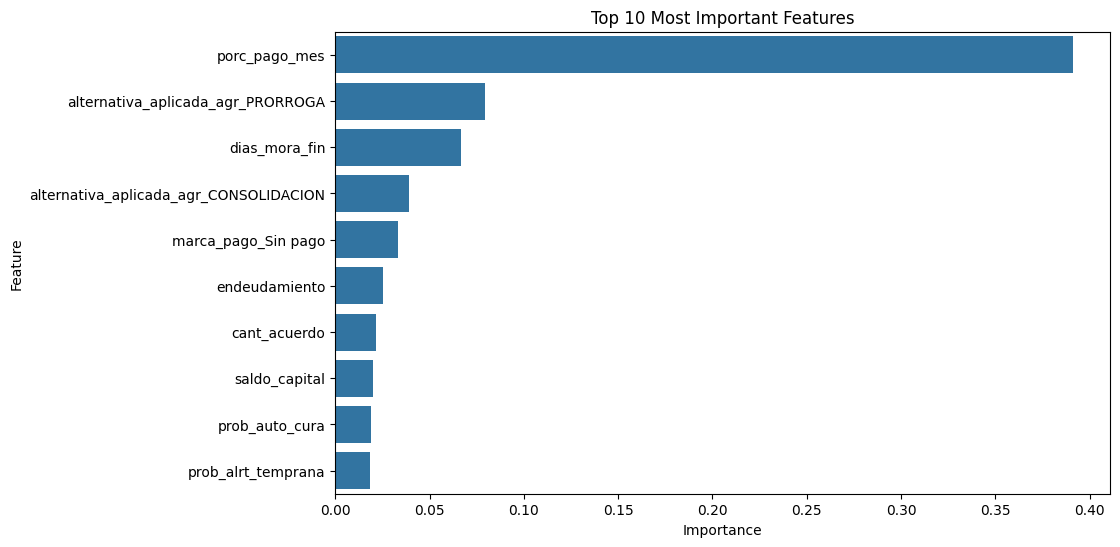

In [45]:

# Graficar las 10 características más importantes
top_10_features = importance_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Most Important Features')
plt.show()


### **Análisis exploratorio EDA**

In [44]:
# Convertir las variables de texto a categóricas
for column in data_merged4.select_dtypes(include='object').columns:
    data_merged4[column] = data_merged4[column].astype('category')

# Generar el informe de perfil
profile = ProfileReport(data_merged4, title='Informe EDA de data_rpta', explorative=True, minimal=True, 
                        vars={
                                "cat": {"characters": False},  
                                "text": {"characters": False, "words": True}},  # Incluir frecuencia de palabras en variables de texto
                        plot={"wordcloud": False},  # Deshabilitar wordcloud
                        interactions={"continuous": False},
                        correlations={"cramers": {"calculate": True}}  # Incluir correlación de Cramér para categorías
                        )

# Mostrar el informe como un iframe HTML
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### **Desarrollo del modelo**

In [54]:
df=data_merged4

In [55]:
## Separar los datos de validación fuera de muestra (fecha_var_rpta_alt = 202312)
validation_mask = df.index.get_level_values('fecha_var_rpta_alt') == '202312'
df_val = df[validation_mask]
df_train_test = df[~validation_mask]

# Separar la variable de respuesta y las características para entrenamiento y prueba
X = df_train_test.drop(columns=['var_rpta_alt'])
y = df_train_test['var_rpta_alt']


## Tamaño de la muestra (por ejemplo, 10% del conjunto de datos)
sample_fraction = 0.4

## Obtener una muestra aleatoria de X e y
X = X.sample(frac=sample_fraction, random_state=42)
y = y.loc[X.index]  # Asegurar que los índices coincidan



## Separar la variable de respuesta y las características para validación
X_val = df_val.drop(columns=['var_rpta_alt'])
y_val = df_val['var_rpta_alt']

# # Separar la variable de respuesta y las características
# X = df.drop(columns=['var_rpta_alt'])
# y = df['var_rpta_alt']



# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identificar las columnas categóricas y numéricas
categorial_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

In [56]:
# Crear ColumnTransformer para preprocesar los datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes
            ('scaler', StandardScaler())]), numeric_columns),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorial_columns)
    ])

In [57]:
# Usar SelectFromModel para la selección de características con RandomForest
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))

Model: Logistic Regression
Cross-validated F1 Score: 0.89
Accuracy: 0.8869332858288056
F1 Score: 0.8860496715977957
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90     29032
           1       0.95      0.81      0.87     27103

    accuracy                           0.89     56135
   macro avg       0.90      0.88      0.89     56135
weighted avg       0.89      0.89      0.89     56135


--------------------------------------------------

Model: Random Forest
Cross-validated F1 Score: 0.91
Accuracy: 0.9136189543065824
F1 Score: 0.9132560953257479
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     29032
           1       0.96      0.86      0.91     27103

    accuracy                           0.91     56135
   macro avg       0.92      0.91      0.91     56135
weighted avg       0.92      0.91      0.91     56135


------------------

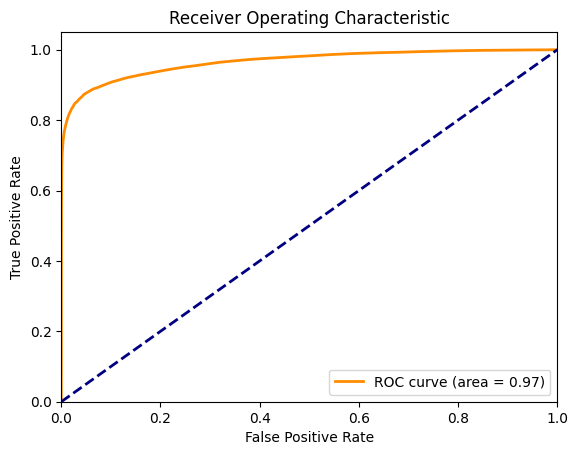

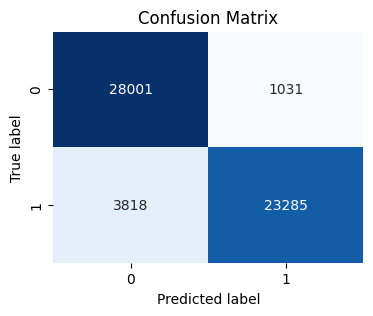

In [58]:
# Definir los modelos a evaluar
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

best_model = None
best_f1_score = 0

# Definir un scorer para el F1 Score
f1_scorer = make_scorer(f1_score, average='weighted')

# Entrenar y evaluar cada modelo con validación cruzada
for model_name, model in models.items():
    # Crear pipeline con preprocesador y modelo
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor), 
                ('classifier', model)])
    
    # # Validación cruzada
    f1_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=f1_scorer, n_jobs=-1)
    mean_f1_score = f1_scores.mean()
    
    print(f"Model: {model_name}")
    print(f"Cross-validated F1 Score: {mean_f1_score:.2f}")
    
    # Entrenar el modelo en el conjunto completo de entrenamiento
    clf.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Calcular y mostrar métricas
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n" + "-"*50 + "\n")
    
    # Seleccionar el modelo con el mejor F1 Score
    if mean_f1_score > best_f1_score:
        best_f1_score = mean_f1_score
        best_model = clf

print(f"El mejor modelo es : {best_model.named_steps['classifier']} con una validación F1 Score de {best_f1_score:.2f}")

# Evaluación del mejor modelo
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Evaluación en el conjunto de validación (fuera de muestra):
Accuracy: 0.8907092946867597
F1 Score: 0.8900186366348535
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90     53425
           1       0.93      0.83      0.88     47041

    accuracy                           0.89    100466
   macro avg       0.90      0.89      0.89    100466
weighted avg       0.89      0.89      0.89    100466



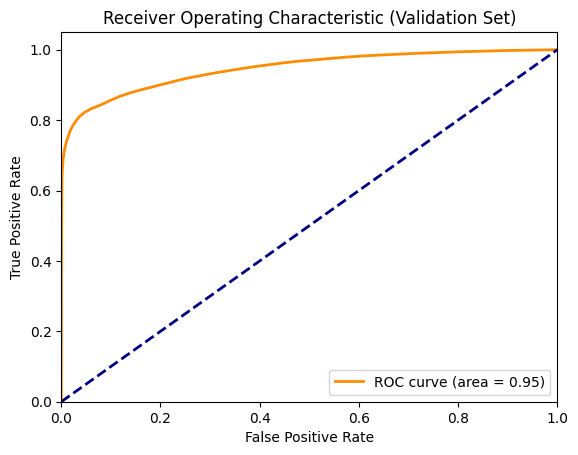

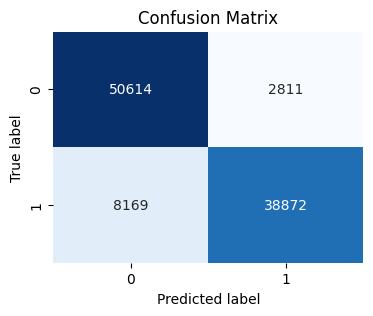

In [59]:
# Transformar el conjunto de validación
X_val_transformed = best_model.named_steps['preprocessor'].transform(X_val)
#X_val_transformed = best_model.named_steps['feature_selector'].transform(X_val_transformed)

# Evaluación del mejor modelo en el conjunto de validación fuera de muestra
y_val_pred = best_model.named_steps['classifier'].predict(X_val_transformed)
y_val_prob = best_model.named_steps['classifier'].predict_proba(X_val_transformed)[:, 1]

# Calcular métricas para el conjunto de validación fuera de muestra
print("Evaluación en el conjunto de validación (fuera de muestra):")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Curva ROC para el conjunto de validación fuera de muestra
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = roc_auc_score(y_val, y_val_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Validation Set)')
plt.legend(loc="lower right")
plt.show()


# Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### Mejorar el modelo con grid search

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint

# Pipeline con preprocesador y clasificador
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])

# Espacio reducido de búsqueda de hiperparámetros
param_dist = {
    'classifier__n_estimators': randint(50, 100),
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': randint(2, 6),
    'classifier__min_samples_leaf': randint(1, 3)
}

# RandomizedSearchCV con menos iteraciones
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,  # Iteraciones reducidas
    cv=3,
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1,
    random_state=42
)

# Entrenamiento en una muestra más pequeña (opcional)
X_train_sample = X_train.sample(frac=0.5, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

random_search.fit(X_train_sample, y_train_sample)

# Resultados
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")


Best parameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 91}
F1 Score: 0.89


El modelo no muestra mejoras haciendo ajuste de hiper parámetros, por lo que se deja como estaba anteriormente.

### Construir la base fuera de muestra de enero 2024

La base de datos con la que se entrenó el modelo esta de 202308 a 202311, se requiere construir la base de enero de 2024, supongamos que la base **prueba_op_base_pivot_var_rpta_alt_enmascarado_oot** es la base de enero, pero esta no tiene las variables, entonces usaremos la base de 202312 como base fuera de muestra para la gestiín de enero 202401.

In [67]:
data_oot.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt
0,257335,444821,635511,202401
1,59584,350400,730364,202401
2,397604,973821,106521,202401
3,368086,382995,696856,202401
4,255009,434238,645924,202401


In [68]:
data_ss.shape

(112549, 2)

In [89]:
# Obtener las probabilidades de predicción y las predicciones del mejor modelo
y_val_prob = best_model.predict_proba(X_val)[:, 1]  # Probabilidad para la clase positiva
y_val_pred = best_model.predict(X_val)  # Predicciones

# Crear un DataFrame con las columnas deseadas
validation_results = X_val.copy()  # Copiar las características de la base de validación
validation_results['Actual'] = y_val  # Agregar las etiquetas reales
validation_results['Predicted'] = y_val_pred  # Agregar las predicciones del modelo
validation_results['Probability_Positive'] = y_val_prob  # Agregar las probabilidades de la clase positiva

# Mostrar las primeras filas del DataFrame
validacion=validation_results.reset_index()


In [90]:
validacion.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,segmento,aplicativo,max_mora,dias_mora_fin,rango_mora,vlr_vencido,saldo_capital,endeudamiento,desc_alternativa1,desc_alternativa2,desc_alternativa3,cant_alter_posibles,alter_posible1_2,alter_posible2_2,alter_posible3_2,cant_gestiones,rpc,promesas_cumplidas,cant_acuerdo,pago_cuota,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,tipo_cli,ctrl_terc,genero_cli,edad_cli,estado_civil,tipo_vivienda,nivel_academico,ocup,act_econom,sector,declarante,total_ing,tot_activos,tot_pasivos,origen_fondos,subsegm,region_of,egresos_mes,tot_patrimonio,prob_propension,prob_alrt_temprana,prob_auto_cura,producto_n,dependientes,antiguedad_años,relacion_pagos,promedio_pagos,promedio_valor_cuota,Actual,Predicted,Probability_Positive
0,309602,28919,752322,202312,Pymes,V,13,0,a.1-30,224751.0,2497081.33,21197557.0,Ampliación de plazo-M,Ampliación 360 -M,Sin alivio,2,TDC10,TDC11,NaN,46.0,1.0,0,2.0,0.0,0.0,0.0,0.0,Sin pago,NO,NaN,NaN,Sin pago,PERSONA JURíDICA,CLIENTE,NaN,NaN,NaN,NaN,NaN,NaN,VENDER Y/O COMPRAR,COMERCIO,S,23421000.0,194010394.0,67339850.0,OTROS,MiPyme,BOGOTA Y CUNDINAMARCA,20742000.0,126670544.0,0.738058,0.662229,0.102105,TARJETA DE CREDITO,SI,10.0,2.000001,2.262902e+05,1.131450e+05,0,0,0.05
1,246252,641802,438540,202312,Personal,L,71,71,b.31-90,600285.0,3593883.00,9750598.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,NaN,NaN,4.0,0.0,0,2.0,0.0,0.0,0.0,0.0,Sin pago,NO,CONSOLIDACION,MODIFICACIÓN,Sin pago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.241550,0.695950,0.214360,LIBRE INVERSION,SI,NaN,1.990159,4.259147e+05,2.140104e+05,1,1,0.99
2,569401,376139,703712,202312,Personal,K,14,14,a.1-30,295313.0,1718494.72,1814615.0,Ampliación de plazo-M,Sin alivio,Sin alivio,1,TDC10,NaN,NaN,8.0,1.0,0,4.0,0.0,0.0,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,PERSONA NATURAL,CLIENTE,M,26.0,SOLTERO,NaN,NaN,ESTUDIANTE,ASALARIADO,PERSONAS,N,838804.0,1325000.0,0.0,SALARIO Y DEMAS PAGOS LABORALES,BASICO,CENTRO,300000.0,1325000.0,0.607216,0.518983,0.310037,TARJETA DE CREDITO,NO,8.0,1.656013,3.425391e+05,2.068457e+05,0,0,0.00
3,538878,498846,581496,202312,Personal,L,109,109,b.31-90,121556.0,1000000.00,32895700.0,Combo reestructuracion,Prórroga reestructuración,Reestructuración novacion,3,CON24,CON26,CON22,34.0,1.0,0,0.0,0.0,0.0,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,PERSONA NATURAL,CLIENTE,M,35.0,UNION LIBRE,NaN,NaN,EMPLEADO,ASALARIADO,PERSONAS,N,1572731.0,26395000.0,350000.0,SALARIO Y DEMAS PAGOS LABORALES,MEDIO,SUR,1000000.0,26045000.0,0.090651,0.751373,0.125559,ROTATIVOS,NO,6.0,0.177945,1.821192e+04,1.023458e+05,0,0,0.10
4,55073,828616,251726,202312,Personal,L,106,106,b.31-90,6587445.0,70106275.32,77774422.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,NaN,NaN,26.0,1.0,0,0.0,0.0,0.0,0.0,0.0,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,PERSONA NATURAL,CLIENTE,M,48.0,SOLTERO,NaN,NO INFORMA,EMPLEADO,ASALARIADO,PERSONAS,N,2175561.0,46651000.0,0.0,SALARIO Y DEMAS PAGOS LABORALES,MEDIO,ANTIOQUIA,250000.0,46651000.0,0.241149,0.721630,0.166134,LIBRE INVERSION,SI,17.0,0.977074,1.813069e+06,1.855611e+06,1,1,1.00


In [91]:
# Concatenar las tres columnas separadas por '#'
validacion['ID'] = (
    validacion['nit_enmascarado'].astype(str) + '#' +
    validacion['num_oblig_orig_enmascarado'].astype(str) + '#' +
    validacion['num_oblig_enmascarado'].astype(str)
)
# Añadir la columna `var_rpta_alt` de `df_val` al DataFrame de resultados
validacion['var_rpta_alt'] = df_val[['var_rpta_alt']].reset_index(drop=True)

# Seleccionar solo las columnas necesarias
final_validation_results = validacion[['ID', 'var_rpta_alt', 'Probability_Positive']]

# Renombrar la columna `Probability_Positive` a `var_rpta_alt Prob_uno`
final_validation_results.rename(columns={'Probability_Positive': 'Prob_uno'}, inplace=True)

# Mostrar las primeras filas del resultado final
final_validation_results.head(10)



In [94]:
final_validation_results.to_csv("resultado_prueba.csv", index=False, encoding="utf-8")
